In [1]:
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
import mne
import tensorflow as tf
import numpy as np
from numpy.lib.utils import safe_eval
from keras.models import load_model
import keras.backend as K
import glob
import scipy.signal
import scipy.io as scio
import MIC
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)
# % 模型准备 %
model_path = r'../others/Gao_Novel_CNN_RNN16_2561630689427.h5'
model = load_model(model_path, custom_objects={'pearson_r': pearson_r})

In [3]:
# 一些快捷调用
# 显示所有事件
def show_events(raw):
    events_from_annot, event_dict = mne.events_from_annotations(raw)
    print(event_dict)
    print(events_from_annot)

# 查看对应id的事件 custom_mapping是一个字典，格式为{'event_name':event_id}
def show_mapping_event(raw,custom_mapping):
    (events_from_annot, event_dict) = mne.events_from_annotations(raw, event_id=custom_mapping)
    print(event_dict)
    print(events_from_annot)

In [5]:
# MIC结果矩阵可视化
def ShowHeatMap(DataFrame,edf_name):
    colormap = plt.cm.RdBu
    ylabels = DataFrame.columns.values.tolist()
    f, ax = plt.subplots(figsize=(14, 14))
    ax.set_title('GRA HeatMap')
    sns.heatmap(DataFrame.astype(float),
                cmap=colormap,
                ax=ax,
                annot=True,
                yticklabels=ylabels,
                xticklabels=ylabels)
    plt.savefig('../img/'+edf_name+'.png')
    plt.show()

In [6]:
def mainfunc(path):
    select_time = 2#抽取2s的片段，可修改为偶数秒  
    channel_count=4
    samps = int(select_time * 256)
    for path_temp in glob.glob(path+r"/**/*.edf",recursive=True):
        path_temp=path_temp.replace('\\','/')#edf文件绝对路径
        edf_name=path_temp.split('/')[-1].split('.')[0]#edf文件名
        raw=read_raw_edf(path_temp,preload=False)
        data,time = raw[:]       
        events_from_annot, event_dict = mne.events_from_annotations(raw)
        SE_time=events_from_annot[event_dict['SE']-2][0]#SE_time为平静期开始
        recover_period=events_from_annot[-2][0]#recover_period为恢复期
        data_before_ect = data[:channel_count,SE_time:SE_time+select_time*512]
        data_after_ect = data[:channel_count,recover_period:recover_period+select_time*512]
        print("data_before_ect",data_before_ect.shape)
        
        # 重采样为256Hz
        data_before_ect_256 = []
        data_after_ect_256 = []
        for i in range(data_before_ect.shape[0]):
            data_temp = scipy.signal.resample(data_before_ect[i],samps)
            data_before_ect_256.append(data_temp)
            data_temp = scipy.signal.resample(data_after_ect[i],samps)
            data_after_ect_256.append(data_temp)
            # 重新转换为np.array
        data_before_ect_256 = np.array(data_before_ect_256)
        data_after_ect_256 = np.array(data_after_ect_256)                                    
        print("data_before_ect_256.shape",data_before_ect_256.shape)
        
        # 分成 epoches，256*2的形状
        # 对每个通道
        data_before_ect_256_samples = []
        data_after_ect_256_samples = []
        for i in range(data_before_ect_256.shape[0]):
            # 进行片段切片
            channel_before = data_before_ect_256[i];
            channel_after = data_after_ect_256[i];
            # samps = 2*256 两秒，每秒256个采样点
            data_before_channels = []
            data_after_channels = []
            for j in range(0,channel_before.shape[0],2*256):
                # print("第" + str(j//samps) + "个片段")
                # 电击前
                data_temp = channel_before[j:j+2*256]
                data_before_channels.append(data_temp)
                # 电击后
                data_temp = channel_after[j:j+2*256]
                data_after_channels.append(data_temp)
            # 每个通道整合起来
            data_before_ect_256_samples.append(data_before_channels)
            data_after_ect_256_samples.append(data_after_channels)
        # 转回np.array
        data_before_ect_256_samples = np.array(data_before_ect_256_samples)
        data_after_ect_256_samples = np.array(data_after_ect_256_samples)
        print("data_before_ect_256_samples.shape",data_before_ect_256_samples.shape)
                                      
        # 进行标准化处理,sta表示Standardization
        data_before_sta = []
        data_after_sta = []
        # 对每个通道
        for i in range(data_before_ect_256_samples.shape[0]):
            # np.mean和np.std计算均值和标准差

            # 先计算电击前
            tmp_mean = np.mean(data_before_ect_256_samples[i])
            tmp_std = np.std(data_before_ect_256_samples[i])
            data_temp_std = (data_before_ect_256_samples[i] - tmp_mean) / tmp_std
            data_before_sta.append(data_temp_std)
            # 计算电击后
            tmp_mean = np.mean(data_after_ect_256_samples[i])
            tmp_std = np.std(data_after_ect_256_samples[i])
            data_temp_std = (data_after_ect_256_samples[i] - tmp_mean) / tmp_std
            data_after_sta.append(data_temp_std)
        # 转回np.array
        data_before_sta = np.array(data_before_sta)
        data_after_sta = np.array(data_after_sta)
        print("data_before_sta.shape",data_before_sta.shape)                              
                                      
        # 整理成神经网络训练所需的形状，这里把数据展平成一维，所有通道合并，之后再还原
        data_before_sta = data_before_sta.reshape(-1,512,1)
        data_after_sta = data_after_sta.reshape(-1,512,1)
        # 模型进行预测
        y_before_pred = model.predict(data_before_sta, verbose=0)
        y_after_pred = model.predict(data_after_sta, verbose=0)
        # 先把通道分开
        # data_before_ect_256_samples.shape[1] = 30 即降采样后的片段数
        pred_before_channel = []
        pred_after_channel = []
        for i in range(0,y_before_pred.shape[0],data_before_ect_256_samples.shape[1]):
            # 先操作电击前
            channel_temp = y_before_pred[i:i+data_before_ect_256_samples.shape[1]]
            channel_temp = channel_temp.flatten()
            pred_before_channel.append(channel_temp)
            # 然后是电击后
            channel_temp = y_after_pred[i:i+data_before_ect_256_samples.shape[1]]
            channel_temp = channel_temp.flatten()
            pred_after_channel.append(channel_temp)
        pred_before_channel = np.array(pred_before_channel)
        pred_after_channel = np.array(pred_after_channel)
        print("pred_before_channel.shape",pred_before_channel.shape)
        # 升采样
        pred_before_rasample = []
        pred_after_resample = []
        for i in range(pred_before_channel.shape[0]):
            # 升采样为原来每个通道的采样点数，秒数*原采样率
            resample_temp = scipy.signal.resample(pred_before_channel[i],len(data_before_ect[0]))
            pred_before_rasample.append(resample_temp)

            resample_temp = scipy.signal.resample(pred_after_channel[i],len(data_after_ect[0]))
            pred_after_resample.append(resample_temp)
        # 转回np.array
        pred_before_rasample = np.array(pred_before_rasample)
        pred_after_resample = np.array(pred_before_rasample)     
        print("pred_before_rasample.shape",pred_before_rasample.shape)
        
        #调用MIC
        mic_tool = MIC.CyrusMIC()
        # 定义每次计算MIC的时间片段，单位：秒
        time_compare = select_time
        # channel_count * channel_count  
        MIC_matrix = []
        for i in range(channel_count):
            # 这个记录单个通道对其他通道的MIC值
            mic_raw = []
            for j in range(channel_count):
                # 上半矩阵为空
                if i<=j:
                    mic_raw.append(0)
                else:
                    # 这个记录单个通道每个片段比较的MIC值
                    mic_raw_temp = []
                    # 每次小循环计算一个片段
                    for z in range(0,pred_before_rasample.shape[1],512*time_compare):
                        print("In calculation " + str(i) + " and " + str(j) +"， ronud: "+ str(z//(512*time_compare)))
                        mic_temp = mic_tool.cal_MIC(pred_before_rasample[i,z:z+512*time_compare],pred_before_rasample[j,z:z+512*time_compare])
                        mic_raw_temp.append(mic_temp)
                    # 把所有片段中的最大值加进mic_raw，作为i与j的MIC值
                    mic_raw_temp = np.array(mic_raw_temp)
                    Max = max(mic_raw_temp)
                    mic_raw.append(Max)

            # 执行一次（i）完整的内循环看一行
            print(mic_raw)
            # 把这个通道的记录加入总的MIC矩阵
            MIC_matrix.append(mic_raw)

        MIC_matrix = np.array(MIC_matrix)
        # 把MIC矩阵存到excel表中
        #修改"MIC_matrix"为文件名
        dataframe = pd.DataFrame(MIC_matrix)
        dataframe.to_excel('../xls/' + edf_name + ".xls")
        ShowHeatMap(dataframe,edf_name)      

In [7]:
#  for i in glob.glob(r"E:/jupyter file/EEG_process/病人数据/第二批数据/**/*.edf",recursive=True):
#      i=i.replace('\\','/')
#      print(i.split('/')[-1].split('.')[0])

Extracting EDF parameters from E:\jupyter file\EEG_process\病人数据\第二批数据\高志20211025.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['File Create', 'Recording ends', 'Recording starts', 'SE', 'Â½Ã¡', 'Â¿Âª']
data_before_ect (4, 1024)
data_before_ect_256.shape (4, 512)
data_before_ect_256_samples.shape (4, 1, 512)
data_before_sta.shape (4, 1, 512)
pred_before_channel.shape (4, 512)
pred_before_rasample.shape (4, 1024)
[0, 0, 0, 0]
In calculation 1 and 0， ronud: 0
2021-11-30 18:52:47,740 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.03275157819292798
[0.03275157819292798, 0, 0, 0]
In calculation 2 and 0， ronud: 0
2021-11-30 18:52:53,316 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.026060667677567487
In calculation 2 and 1， ronud: 0
2021-11-30 18:52:58,971 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.24581117835973829
[0.026060667677567487, 0.24581117835973829, 0, 0]
In calculation 3 and 0， ronud: 0
2021-11-30 18:53:04,610 - MIC.cal_MIC:73 - INFO 

<ipython-input-6-3db3c8c339b0>:151: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  dataframe.to_excel('E:\\jupyter file\\EEG_process\\xls\\' + edf_name + ".xls")


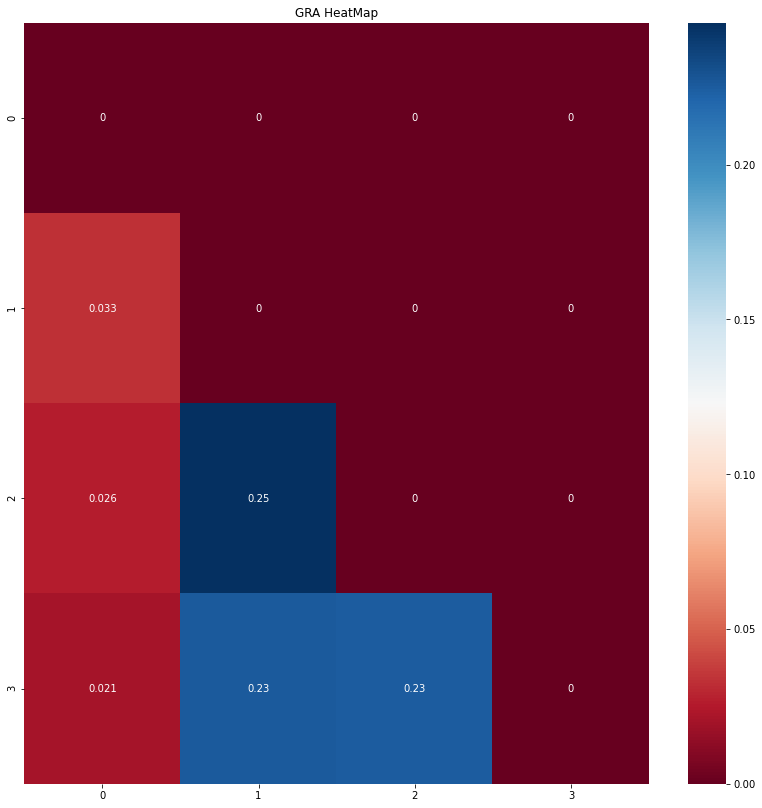

Extracting EDF parameters from E:\jupyter file\EEG_process\病人数据\第二批数据\黄聘婷20211025.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Recording ends', 'Recording starts', 'SE', 'Â½Ã¡', 'Â¿Âª']
data_before_ect (4, 1024)
data_before_ect_256.shape (4, 512)
data_before_ect_256_samples.shape (4, 1, 512)
data_before_sta.shape (4, 1, 512)
pred_before_channel.shape (4, 512)
pred_before_rasample.shape (4, 1024)
[0, 0, 0, 0]
In calculation 1 and 0， ronud: 0
2021-11-30 18:53:22,426 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.2599882505321751
[0.2599882505321751, 0, 0, 0]
In calculation 2 and 0， ronud: 0
2021-11-30 18:53:28,090 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.1712086577768841
In calculation 2 and 1， ronud: 0
2021-11-30 18:53:33,691 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.21449789731661548
[0.1712086577768841, 0.21449789731661548, 0, 0]
In calculation 3 and 0， ronud: 0
2021-11-30 18:53:39,369 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.15486593

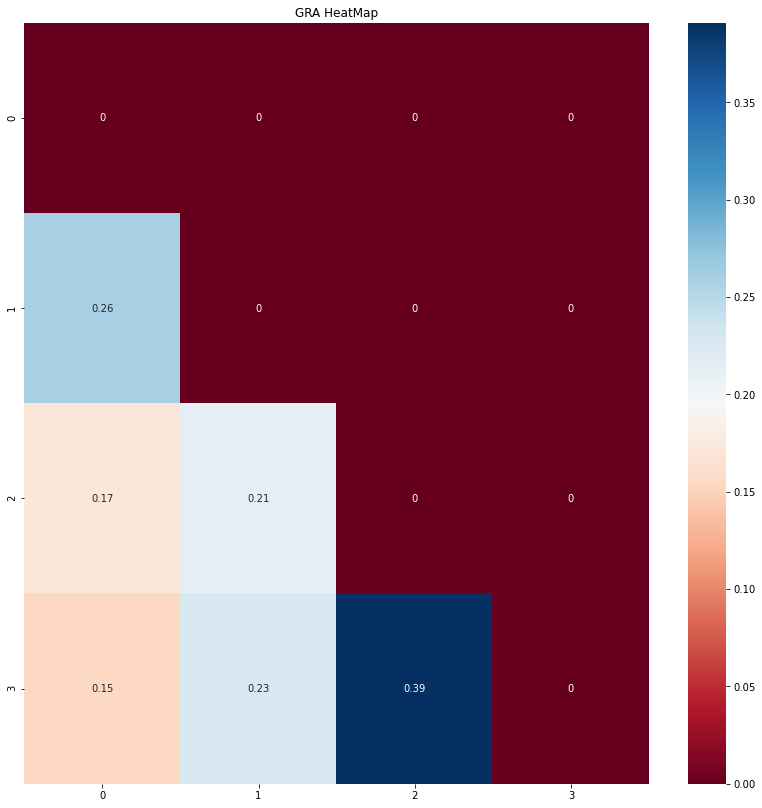

Extracting EDF parameters from E:\jupyter file\EEG_process\病人数据\第二批数据\曲燕飞\曲燕飞20211011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Recording ends', 'Recording starts', 'SE', 'Â½Ã¡', 'Â¿Âª']
data_before_ect (4, 1024)
data_before_ect_256.shape (4, 512)
data_before_ect_256_samples.shape (4, 1, 512)
data_before_sta.shape (4, 1, 512)
pred_before_channel.shape (4, 512)
pred_before_rasample.shape (4, 1024)
[0, 0, 0, 0]
In calculation 1 and 0， ronud: 0
2021-11-30 18:53:56,890 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.27373346088846945
[0.27373346088846945, 0, 0, 0]
In calculation 2 and 0， ronud: 0
2021-11-30 18:54:02,596 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.16171479640833591
In calculation 2 and 1， ronud: 0
2021-11-30 18:54:08,296 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.11675259662936702
[0.16171479640833591, 0.11675259662936702, 0, 0]
In calculation 3 and 0， ronud: 0
2021-11-30 18:54:13,944 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.

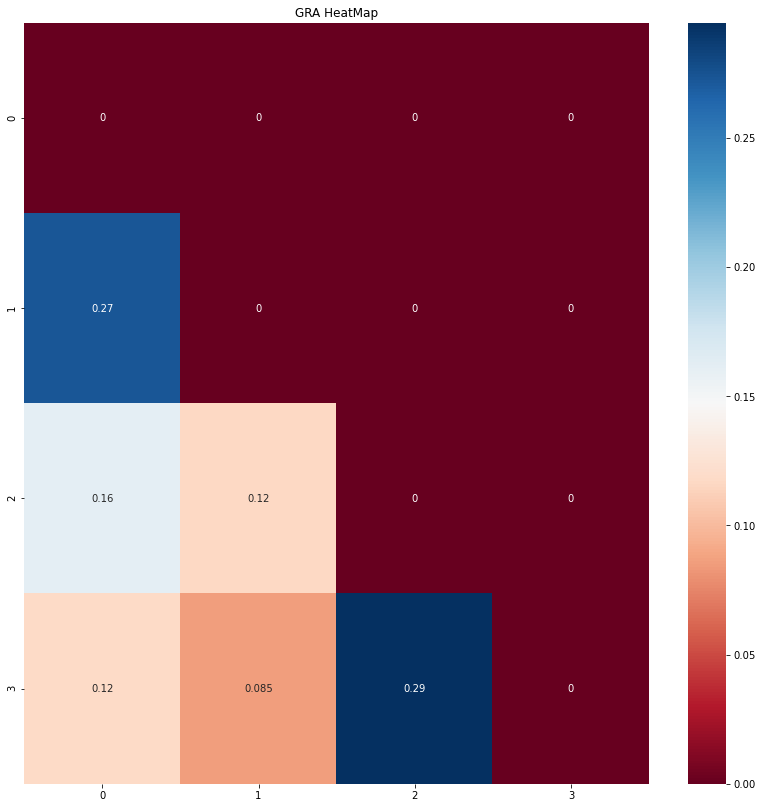

Extracting EDF parameters from E:\jupyter file\EEG_process\病人数据\第二批数据\曲燕飞\曲燕飞20211013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['File Create', 'Recording ends', 'Recording starts', 'SE', 'Â½Ã¡', 'Â¿Âª']
data_before_ect (4, 1024)
data_before_ect_256.shape (4, 512)
data_before_ect_256_samples.shape (4, 1, 512)
data_before_sta.shape (4, 1, 512)
pred_before_channel.shape (4, 512)
pred_before_rasample.shape (4, 1024)
[0, 0, 0, 0]
In calculation 1 and 0， ronud: 0
2021-11-30 18:54:31,690 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.2568034622510582
[0.2568034622510582, 0, 0, 0]
In calculation 2 and 0， ronud: 0
2021-11-30 18:54:37,196 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.2933049035344077
In calculation 2 and 1， ronud: 0
2021-11-30 18:54:42,710 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.3051642197275552
[0.2933049035344077, 0.3051642197275552, 0, 0]
In calculation 3 and 0， ronud: 0
2021-11-30 18:54:48,293 - MIC.cal_MIC:73 - INFO - 最

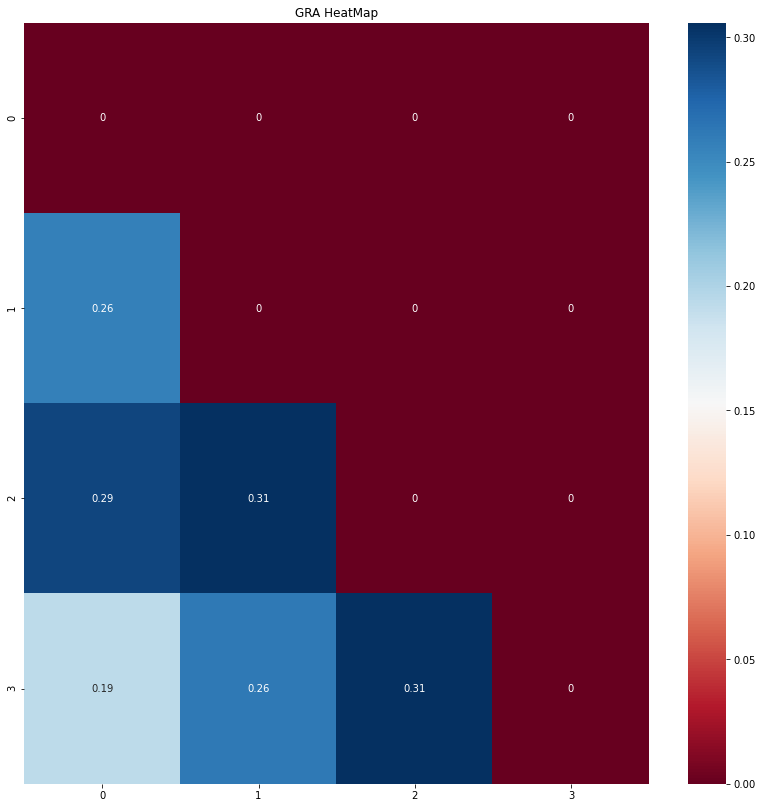

Extracting EDF parameters from E:\jupyter file\EEG_process\病人数据\第二批数据\曲燕飞\曲燕飞20211015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['File Create', 'Recording ends', 'Recording starts', 'SE', 'Â½Ã¡', 'Â¿Âª']
data_before_ect (4, 1024)
data_before_ect_256.shape (4, 512)
data_before_ect_256_samples.shape (4, 1, 512)
data_before_sta.shape (4, 1, 512)
pred_before_channel.shape (4, 512)
pred_before_rasample.shape (4, 1024)
[0, 0, 0, 0]
In calculation 1 and 0， ronud: 0
2021-11-30 18:55:06,449 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.07756385991159362
[0.07756385991159362, 0, 0, 0]
In calculation 2 and 0， ronud: 0
2021-11-30 18:55:12,004 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.026195530970525235
In calculation 2 and 1， ronud: 0
2021-11-30 18:55:17,629 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.07197831214948551
[0.026195530970525235, 0.07197831214948551, 0, 0]
In calculation 3 and 0， ronud: 0
2021-11-30 18:55:23,219 - MIC.cal_MIC:73 - 

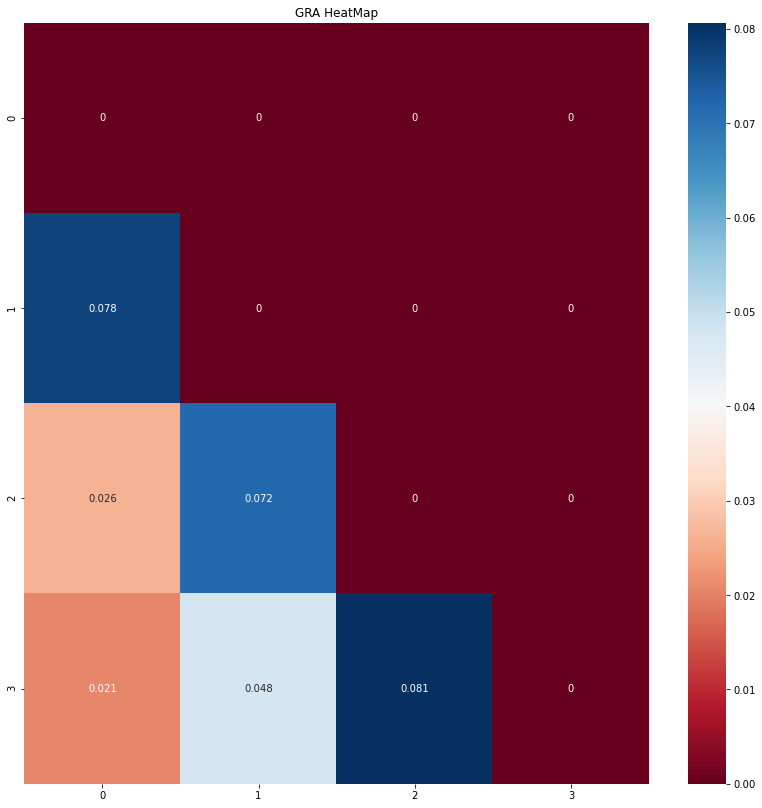

Extracting EDF parameters from E:\jupyter file\EEG_process\病人数据\第二批数据\曲燕飞\曲燕飞20211018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['File Create', 'Recording ends', 'Recording starts', 'SE', 'Â½Ã¡', 'Â¿Âª']
data_before_ect (4, 1024)
data_before_ect_256.shape (4, 512)
data_before_ect_256_samples.shape (4, 1, 512)
data_before_sta.shape (4, 1, 512)
pred_before_channel.shape (4, 512)
pred_before_rasample.shape (4, 1024)
[0, 0, 0, 0]
In calculation 1 and 0， ronud: 0
2021-11-30 18:55:41,093 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.13232536438702283
[0.13232536438702283, 0, 0, 0]
In calculation 2 and 0， ronud: 0
2021-11-30 18:55:46,505 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.07135715252308715
In calculation 2 and 1， ronud: 0
2021-11-30 18:55:52,049 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.05150356819947593
[0.07135715252308715, 0.05150356819947593, 0, 0]
In calculation 3 and 0， ronud: 0
2021-11-30 18:55:57,800 - MIC.cal_MIC:73 - IN

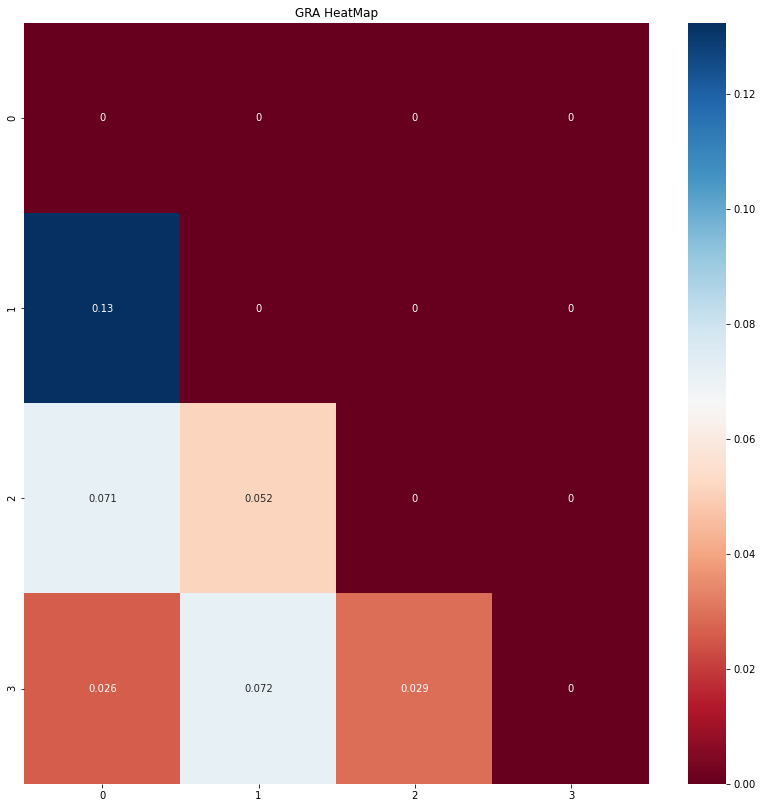

Extracting EDF parameters from E:\jupyter file\EEG_process\病人数据\第二批数据\曲燕飞\曲燕飞20211020.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['File Create', 'Recording ends', 'Recording starts', 'SE', 'Â½Ã¡', 'Â¿Âª']
data_before_ect (4, 1024)
data_before_ect_256.shape (4, 512)
data_before_ect_256_samples.shape (4, 1, 512)
data_before_sta.shape (4, 1, 512)
pred_before_channel.shape (4, 512)
pred_before_rasample.shape (4, 1024)
[0, 0, 0, 0]
In calculation 1 and 0， ronud: 0
2021-11-30 18:56:17,837 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.22965515801944084
[0.22965515801944084, 0, 0, 0]
In calculation 2 and 0， ronud: 0
2021-11-30 18:56:24,370 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.19115191137122015
In calculation 2 and 1， ronud: 0
2021-11-30 18:56:30,755 - MIC.cal_MIC:73 - INFO - 最大信息系数为:0.19783673229170548
[0.19115191137122015, 0.19783673229170548, 0, 0]
In calculation 3 and 0， ronud: 0
2021-11-30 18:56:37,879 - MIC.cal_MIC:73 - IN

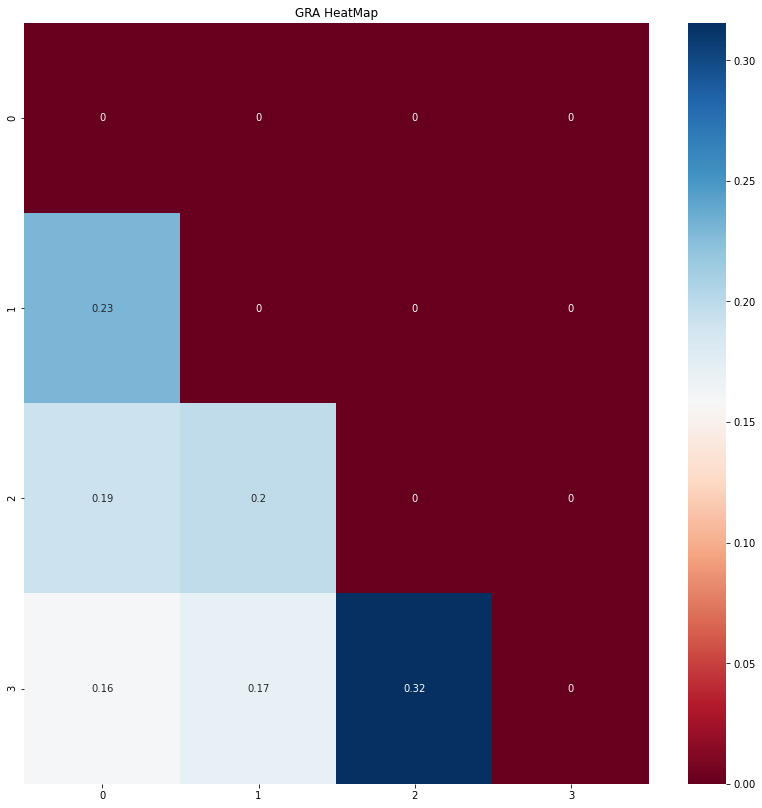

In [8]:
mainfunc(r"E:/jupyter file/EEG_process/病人数据/第二批数据")